## Task 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from pycocotools.coco import COCO
import os

In [3]:
fixed_size = (256, 256)
coco_val_ann_file = "C:/Users/chaha/Desktop/VisionExtract/annonations/instances_val2017.json"
coco_val_img_dir = "C:/Users/chaha/Desktop/VisionExtract/val2017"

In [4]:
coco = COCO(coco_val_ann_file)
val_img_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [5]:
def load_image_and_binary_mask(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(coco_val_img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

### Original Images with masks

In [6]:
num_samples = 5
sample_img_ids = random.sample(val_img_ids, num_samples)

original_images = []
original_masks = []

for img_id in sample_img_ids:
    img, msk = load_image_and_binary_mask(img_id)
    img_resized = cv2.resize(img, fixed_size)
    msk_resized = cv2.resize(msk, fixed_size, interpolation=cv2.INTER_NEAREST)
    original_images.append(img_resized)
    original_masks.append(msk_resized)

In [7]:
def plot_images_with_masks(images, masks, title):
    n = len(images)
    fig, axes = plt.subplots(n, 2, figsize=(10, 5*n))
    fig.suptitle(title, fontsize=16)
    for i in range(n):
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Original Image")
        mask = masks[i]
        colored_mask = np.zeros_like(images[i], dtype=np.uint8)
        colored_mask[:, :, 0] = 255
        alpha = 0.5
        overlay = images[i].copy()
        overlay[mask > 0] = cv2.addWeighted(images[i][mask > 0], 1 - alpha, colored_mask[mask > 0], alpha, 0)
        axes[i, 1].imshow(overlay)
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Image with Mask Highlighted")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


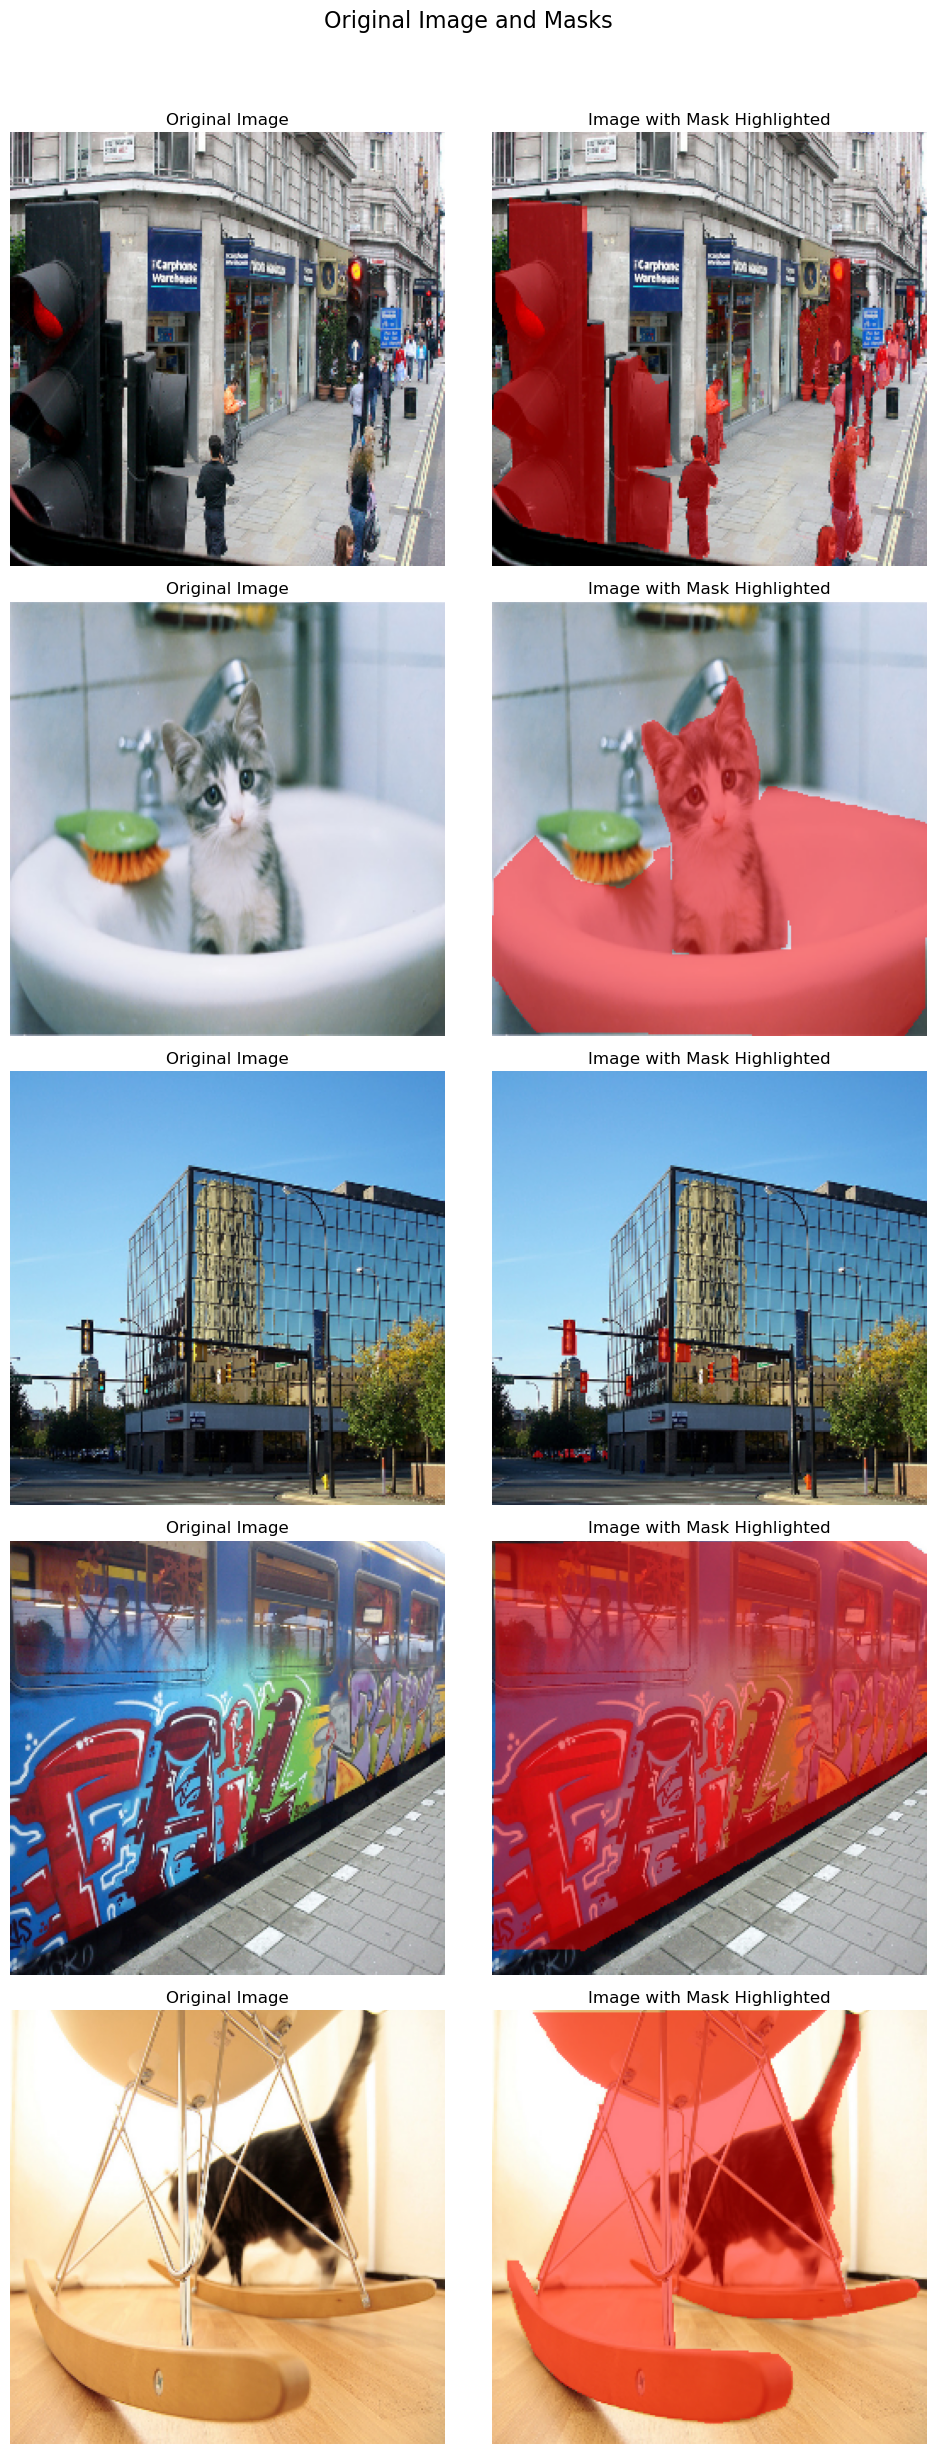

In [8]:
plot_images_with_masks(original_images, original_masks, "Original Image and Masks")

### Augmented and Normalized Images with Masks

In [9]:
def random_flip(image, mask):
    if random.random() > 0.5:
        image = cv2.flip(image, 1) 
        mask = cv2.flip(mask, 1)
    return image, mask

def random_rotate(image, mask, max_angle=15):
    angle = random.uniform(-max_angle, max_angle)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
    image_rot = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    mask_rot = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REFLECT)
    return image_rot, mask_rot

def random_brightness_contrast(image, brightness_limit=0.2, contrast_limit=0.2):
    brightness = random.uniform(-brightness_limit, brightness_limit)
    contrast = random.uniform(-contrast_limit, contrast_limit)
    img = image.astype(np.float32) / 255.0
    img = img * (1 + contrast) + brightness
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return img

def normalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = image.astype(np.float32) / 255.0
    img = (img - mean) / std
    return img

In [14]:
num_samples = 7
sample_img_ids = random.sample(val_img_ids, num_samples)

aug_images = []
aug_masks = []

for img_id in sample_img_ids:
    img, msk = load_image_and_binary_mask(img_id)
    img = cv2.resize(img, fixed_size)
    msk = cv2.resize(msk, fixed_size, interpolation=cv2.INTER_NEAREST)
    img, msk = random_flip(img, msk)
    img, msk = random_rotate(img, msk)
    img = random_brightness_contrast(img)
    img_norm = normalize(img)
    aug_images.append(img_norm)
    aug_masks.append(msk)

In [15]:
def plot_augmented_images_with_masks(images, masks, title):
    fig, axes = plt.subplots(len(images), 2, figsize=(8, 4*len(images)))
    fig.suptitle(title, fontsize=16)
    for i in range(len(images)):
        img = images[i]
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = (img * std + mean)
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Augmented Image")
        binary_mask = (masks[i] > 0).astype(np.uint8) * 255
        axes[i, 1].imshow(binary_mask, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Binary Mask")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

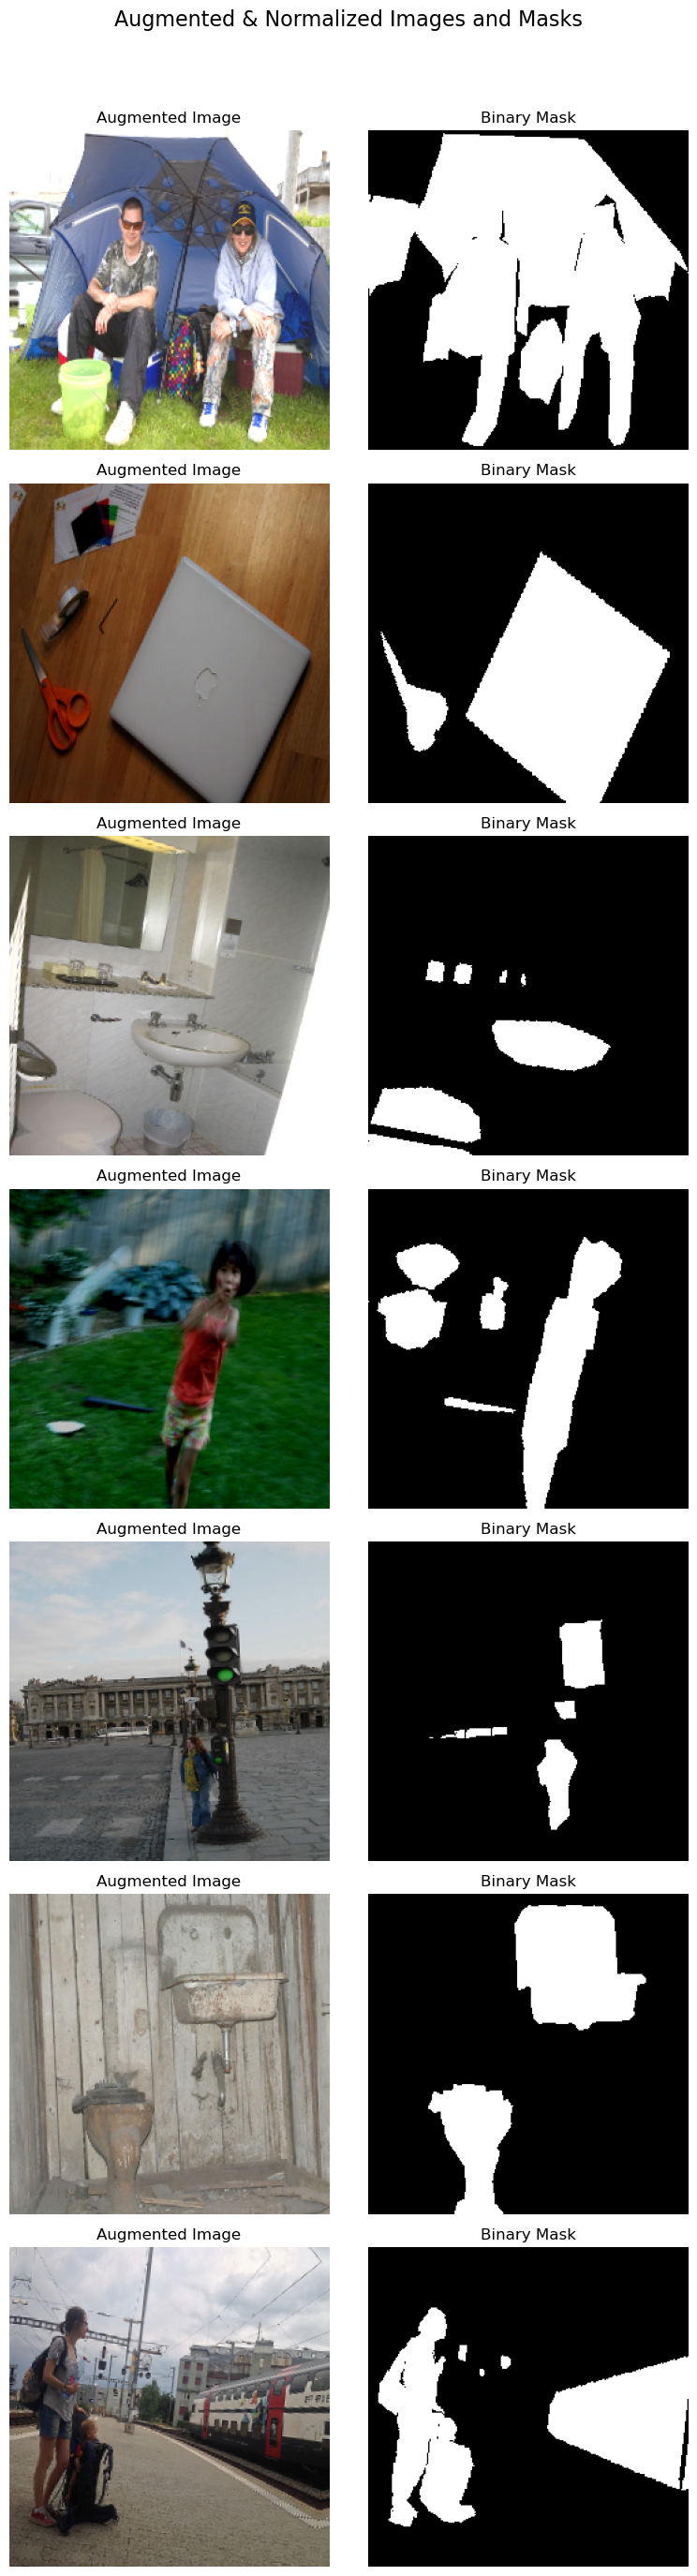

In [16]:
plot_augmented_images_with_masks(aug_images, aug_masks, "Augmented & Normalized Images and Masks")

## Task 2

In [21]:
OUT_SIZE = (224, 224)   
NUM_SAMPLES = 5    

def normalize_image(img):
    return img.astype(np.float32) / 255.0
def augment_image_and_mask(img, mask):
    h, w = img.shape[:2]
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
        mask = cv2.flip(mask, 1)
    angle = random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    mask = (mask > 0).astype(np.uint8)
    return img, mask

In [24]:
cow_cat_ids = coco.getCatIds(catNms=['cow'])
val_img_ids = coco.getImgIds(catIds=cow_cat_ids)
print("Total cow images:", len(val_img_ids))

Total cow images: 87


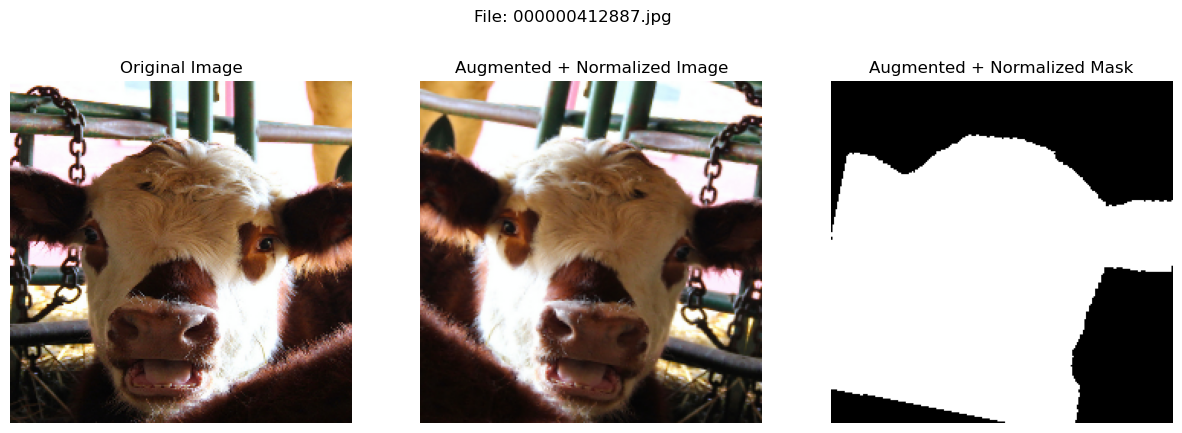

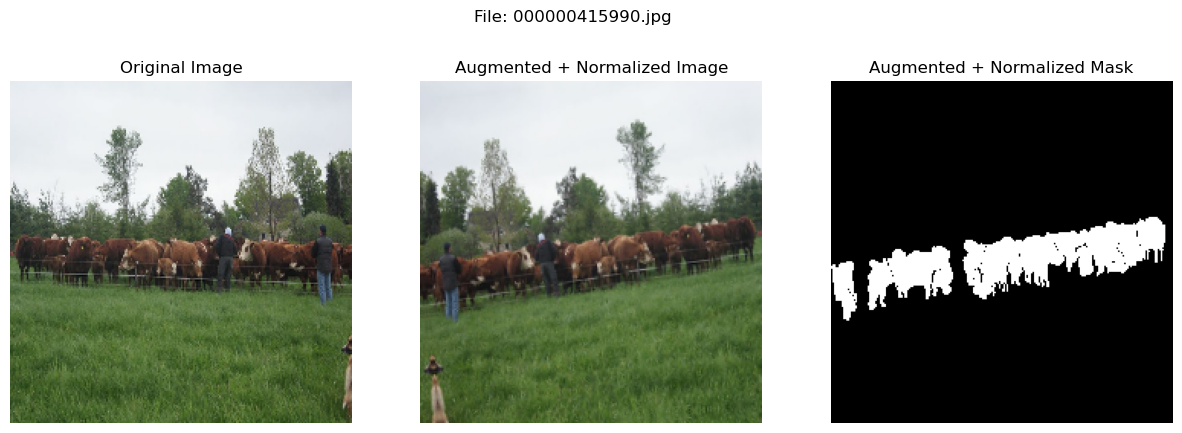

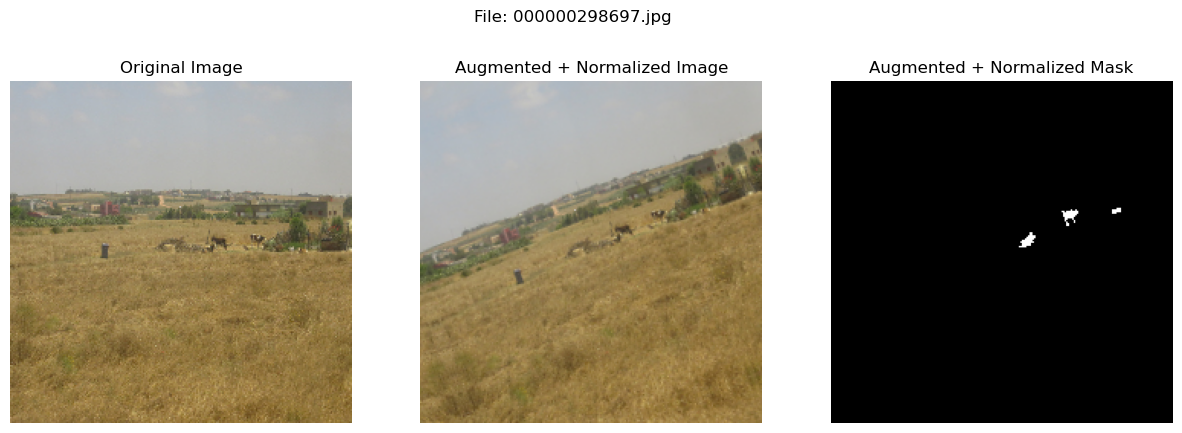

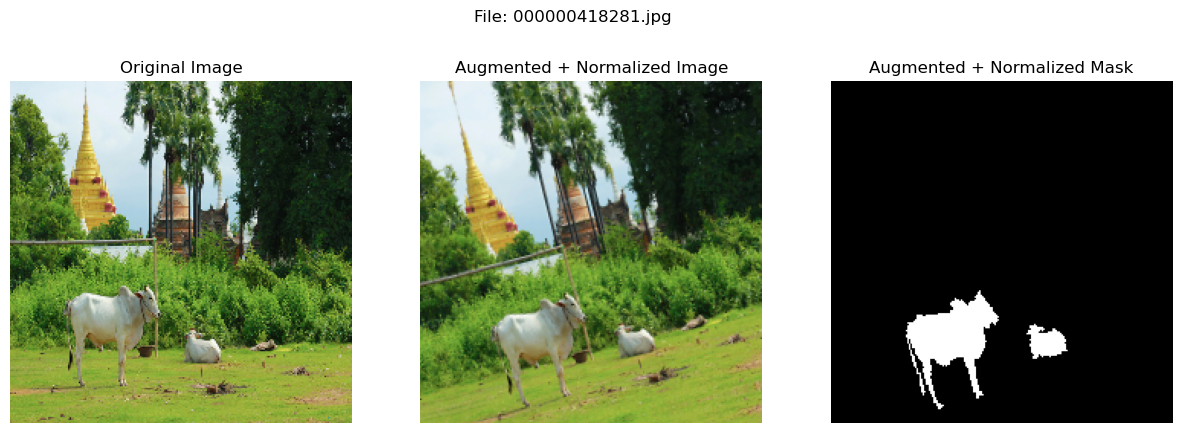

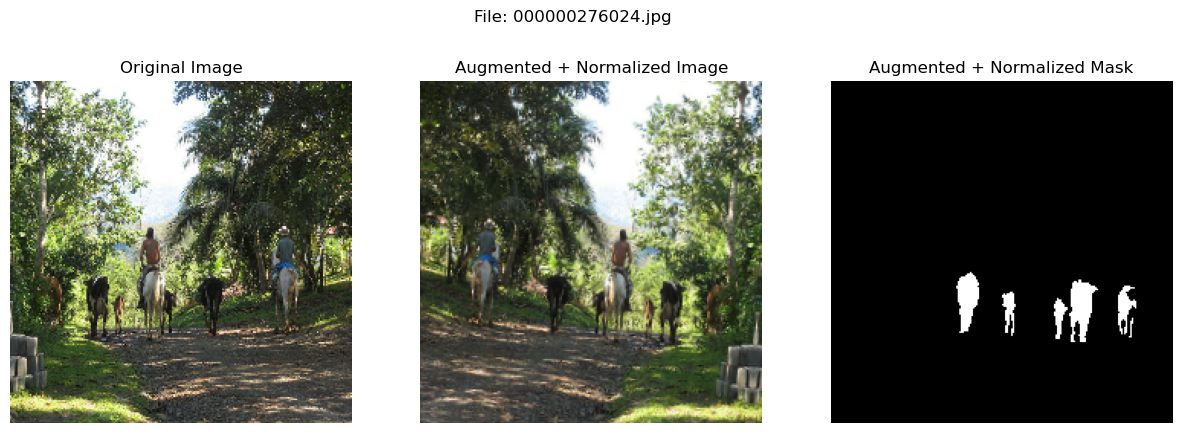

In [25]:
sample_img_ids = random.sample(val_img_ids, NUM_SAMPLES)

for img_id in sample_img_ids:
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(coco_val_img_dir, img_info['file_name'])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cow_cat_ids)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    image = cv2.resize(image, OUT_SIZE, interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, OUT_SIZE, interpolation=cv2.INTER_NEAREST)
    aug_img, aug_mask = augment_image_and_mask(image.copy(), mask.copy())
    aug_img_norm = normalize_image(aug_img)
    aug_mask_norm = (aug_mask > 0).astype(np.float32)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image); axes[0].set_title("Original Image"); axes[0].axis("off")
    axes[1].imshow(aug_img_norm); axes[1].set_title("Augmented + Normalized Image"); axes[1].axis("off")
    axes[2].imshow(aug_mask_norm, cmap="gray"); axes[2].set_title("Augmented + Normalized Mask"); axes[2].axis("off")

    plt.suptitle(f"File: {img_info['file_name']}", fontsize=12)
    plt.show()